<a href="https://colab.research.google.com/github/Alejandro-XIII/Proyecto-Fundamentos-de-deep-learning/blob/main/01%20-%20proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de datos

In [1]:
import json
import os

# Tus credenciales de Kaggle
kaggle_credentials = {
    "username": "alejandroxiii",
    "key": "c3b4b0b2db293b9b83ab9543550cd3ba"
}

# Guardar el archivo kaggle.json
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_credentials, f)

# Cambiar permisos
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


In [2]:
!kaggle datasets download -d nibinv23/iam-handwriting-word-database

Dataset URL: https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database
License(s): unknown
 99% 1.09G/1.10G [00:11<00:00, 38.4MB/s]
100% 1.10G/1.10G [00:11<00:00, 103MB/s] 


In [3]:
!unzip iam-handwriting-word-database.zip -d iam_words_dataset

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-03-07.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-03-08.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-03-09.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-03-10.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-04-00.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-04-01.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-04-02.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-04-03.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-04-04.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-04-05.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-04-06.png  
  inflating: iam_words_dataset/iam_words/words/p06/p06-069/p06-069-05-

# Visualización y preparación de datos

## Crear Dataframe con transcripción de cada imagen

In [4]:
import pandas as pd

# Lista para guardar los datos
datos = []

# Abrir y leer línea por línea
with open("iam_words_dataset/words_new.txt", "r") as archivo:
    for linea in archivo:
        # Ignorar líneas vacías o de comentarios
        if linea.startswith("#") or not linea.strip():
            continue
        partes = linea.strip().split()
        word_id = partes[0]
        transcripcion = " ".join(partes[8:])  # desde la columna 8 hasta el final
        datos.append((word_id, transcripcion))

# Crear DataFrame
df = pd.DataFrame(datos, columns=["word_id", "transcripcion"])

# Mostrar las primeras filas
print(df.head())

def obtener_transcripcion(word_id):
    word_id = os.path.splitext(word_id)[0]
    resultado = df[df["word_id"] == word_id]
    if not resultado.empty:
        return resultado.iloc[0]["transcripcion"]
    else:
        return "None"


          word_id transcripcion
0  a01-000u-00-00             A
1  a01-000u-00-01          MOVE
2  a01-000u-00-02            to
3  a01-000u-00-03          stop
4  a01-000u-00-04           Mr.


In [15]:
obtener_transcripcion('d06-020-01-02.png')

'from'

## Visualizar imagenes con su respectiva transcripción

NOTA: Solamente se encuentran transcritas parte de las imágenes, pertenecientes entre el id_inicio e id_final

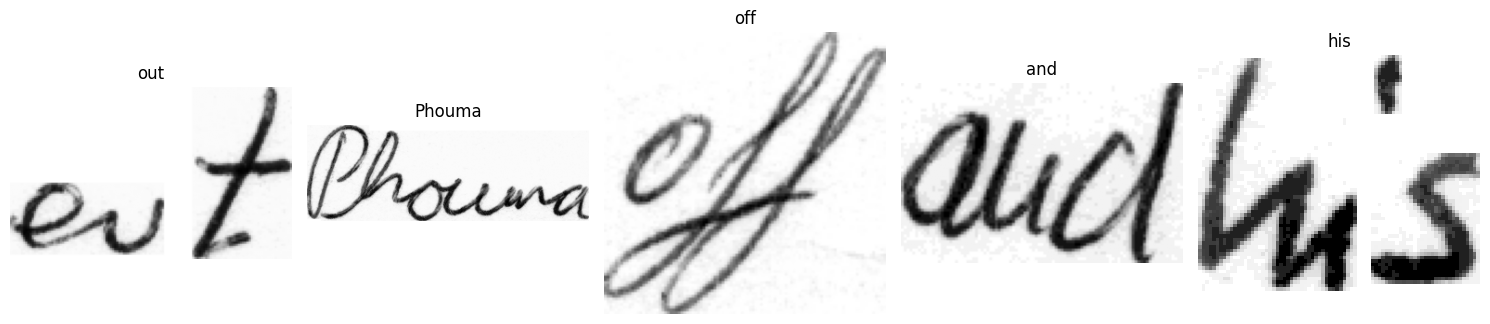

In [9]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ID inicial y final válidos
id_inicio = "a01-000u-00-00.png"
id_final = "e07-072-09-03.png"

# Buscar todas las imágenes dentro de las subcarpetas
image_paths = []
for root, _, files in os.walk("iam_words_dataset"):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Filtrar solo imágenes con IDs dentro del rango permitido
filtradas = []
for path in image_paths:
    word_id = os.path.basename(path)
    if id_inicio <= word_id <= id_final:
        filtradas.append(path)

# Mostrar 5 aleatorias
sample_paths = random.sample(filtradas, min(5, len(filtradas)))

# Mostrar las imágenes
plt.figure(figsize=(15, 5))
for i, path in enumerate(sample_paths):
    img = mpimg.imread(path)
    plt.subplot(1, 5, i + 1)
    transcripcion = obtener_transcripcion(os.path.basename(path))
    plt.imshow(img, cmap='gray')
    plt.title(transcripcion)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Obtener vocabulario y longitud máxima de transcripciones reales

In [42]:
all_text = " ".join(df["transcripcion"])
characters = sorted(set(all_text))
max_len = df["transcripcion"].apply(len).max()

print("Vocab size:", len(characters))
print("Max length:", max_len)

Vocab size: 77
Max length: 19


## Crear el mapeo de letra a número y de número a letra

In [43]:
from tensorflow.keras.layers import StringLookup

# Crear el mapeo de letra a número
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Crear el mapeo de número a letra
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# Verifica el vocabulario
print("Vocabulario:", char_to_num.get_vocabulary())

Vocabulario: ['[UNK]', np.str_(' '), np.str_('!'), np.str_('"'), np.str_('#'), np.str_("'"), np.str_('('), np.str_(')'), np.str_('*'), np.str_(','), np.str_('-'), np.str_('.'), np.str_('/'), np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(':'), np.str_(';'), np.str_('?'), np.str_('A'), np.str_('B'), np.str_('C'), np.str_('D'), np.str_('E'), np.str_('F'), np.str_('G'), np.str_('H'), np.str_('I'), np.str_('J'), np.str_('K'), np.str_('L'), np.str_('M'), np.str_('N'), np.str_('O'), np.str_('P'), np.str_('Q'), np.str_('R'), np.str_('S'), np.str_('T'), np.str_('U'), np.str_('V'), np.str_('W'), np.str_('X'), np.str_('Y'), np.str_('Z'), np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'

## Redimensionar imagenes sin distorsión

In [106]:
import tensorflow as tf

def redimensionar_imagen_simple(imagen, tamaño):
    # Redimensiona manteniendo la relación de aspecto
    imagen = tf.image.resize(imagen, tamaño, preserve_aspect_ratio=True)

    altura_deseada, ancho_deseado = tamaño[1], tamaño[0]
    altura_actual = tf.shape(imagen)[0]
    ancho_actual = tf.shape(imagen)[1]

    pad_alto = altura_deseada - altura_actual
    pad_ancho = ancho_deseado - ancho_actual

    # Si padding es negativo, significa que la imagen es más grande que el tamaño deseado
    # Entonces recortamos (crop) en lugar de rellenar

    # Recorta si padding negativo en alto
    imagen = tf.cond(
        pad_alto < 0,
        lambda: imagen[:altura_deseada, :, :],
        lambda: tf.pad(
            imagen,
            [[pad_alto // 2, pad_alto - pad_alto // 2], [0, 0], [0, 0]],
            constant_values=1.0,
        ),
    )

    # Recorta si padding negativo en ancho
    imagen = tf.cond(
        pad_ancho < 0,
        lambda: imagen[:, :ancho_deseado, :],
        lambda: tf.pad(
            imagen,
            [[0, 0], [pad_ancho // 2, pad_ancho - pad_ancho // 2], [0, 0]],
            constant_values=1.0,
        ),
    )

    return imagen


## Preprocesamiento de la imagen

In [117]:
batch_size = 64
padding_token = 99
image_size = (128, 32)
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=image_size):
    def _load_image(path):
        try:
            image_bytes = tf.io.read_file(path)
            image = tf.image.decode_png(image_bytes, channels=1)
        except Exception as e:
            print(f"Error al leer {path}: {e}")
            # Retornar imagen en blanco si hay error
            image = tf.zeros([img_size[1], img_size[0], 1], dtype=tf.uint8)
        return image

    image = tf.py_function(_load_image, [image_path], tf.uint8)
    image.set_shape([None, None, 1])
    image = redimensionar_imagen_simple(tf.cast(image, tf.float32), img_size)
    image = image / 255.0
    return image


## Vectorizar etiquetas

In [118]:
def vectorize_label_tf(image_path):
    def _get_transcription(path):
        # path es un Tensor, lo convertimos primero a bytes y luego decodificamos
        path_bytes = path.numpy()  # convierte el tensor a bytes
        path_str = path_bytes.decode("utf-8")  # ahora sí puedes decodificar
        word_id_str = path_str.split(os.sep)[-1].replace(".png", "")
        transcription = obtener_transcripcion(word_id_str)
        return transcription.encode("utf-8")  # devolvemos bytes

    # Llamamos a la función Python desde TensorFlow
    transcription = tf.py_function(
        func=_get_transcription,
        inp=[image_path],
        Tout=tf.string
    )
    transcription.set_shape([])  # ← importante: le decimos que es un string escalar

    # Convertimos a secuencia de caracteres
    label = tf.strings.unicode_split(transcription, input_encoding="UTF-8")
    label = char_to_num(label)

    # Padding
    pad_len = tf.maximum(max_len - tf.shape(label)[0], 0)
    label = tf.pad(label, paddings=[[0, pad_len]], constant_values=padding_token)
    return label

## Juntar imagen y etiqueta

In [119]:
def process_image_and_label(image_path):
    image = preprocess_image(image_path)
    label = vectorize_label_tf(image_path)
    return {"image": image, "label": label}

## Preparar dataset

In [120]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(process_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return dataset

# División del conjunto de datos

In [121]:
from sklearn.model_selection import train_test_split

# Dividir: 90% train, 10% resto
train_paths, temp_paths = train_test_split(filtradas, test_size=0.10, random_state=42)

# Dividir el 10% en val y test (5% y 5%)
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

# Filtrar solo rutas no vacías
train_paths = [p for p in train_paths if p.strip() != '']
val_paths = [p for p in val_paths if p.strip() != '']

# Opcional: verificar que los archivos existan
import os
train_paths = [p for p in train_paths if os.path.isfile(p)]
val_paths = [p for p in val_paths if os.path.isfile(p)]

print(f"Total train paths válidos: {len(train_paths)}")
print(f"Total val paths válidos: {len(val_paths)}")

Total train paths válidos: 40107
Total val paths válidos: 2228


In [122]:
train_ds = prepare_dataset(train_paths)
val_ds = prepare_dataset(val_paths)
test_ds = prepare_dataset(test_paths)

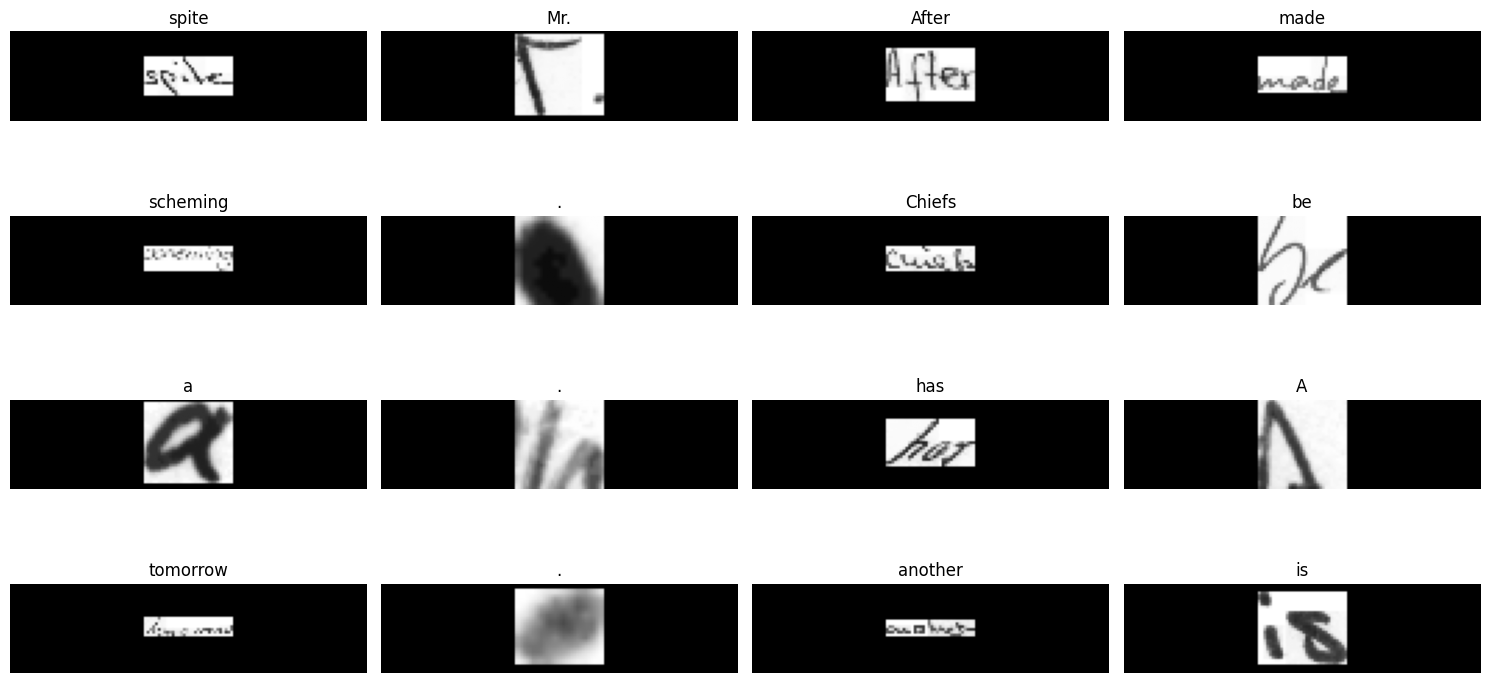

In [123]:
import matplotlib.pyplot as plt
import tensorflow as tf

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = (img * 255.0).numpy().astype("uint8")
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(label != padding_token))
        label_str = tf.strings.reduce_join(num_to_char(indices))
        label_str = label_str.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label_str)
        ax[i // 4, i % 4].axis("off")

plt.tight_layout()
plt.show()

# Modelo

In [124]:
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Durante inferencia retorna las predicciones
        return y_pred


def build_model():
    # Nota: La forma de la imagen es (alto, ancho, canales)
    input_img = keras.Input(shape=(image_height, image_width, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # Bloque convolucional 1
    x = keras.layers.Conv2D(
        32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1"
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Bloque convolucional 2
    x = keras.layers.Conv2D(
        64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2"
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Redimensionar para RNN
    # Después de 2 maxpools con stride 2, tamaño se divide por 4
    # Forma nueva: (ancho / 4, (alto / 4) * filtros)
    new_shape = (image_width // 4, (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)

    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNN Bidireccionales
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 tokens especiales para CTC (espacio y blank token)
    vocab_size = len(char_to_num.get_vocabulary()) + 2
    x = keras.layers.Dense(vocab_size, activation="softmax", name="dense2")(x)

    # Capa CTC para calcular la pérdida
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Definir modelo
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")

    # Compilar
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)

    return model


model = build_model()
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 32, 128,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 128,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 16, 64,    │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 16, 64,    │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 8, 32, 64) │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 512)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 32, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 32, 256)   │    197,632 │ dropout_7[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 32, 128)   │    164,352 │ bidirectional_14… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32, 80)    │     10,320 │ bidirectional_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 80)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,952 (1.62 MB)

 Trainable params: 423,952 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Métricas de Evaluación

In [125]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework import ops

# Extraemos las imágenes y etiquetas de validación para conveniencia
validation_images = []
validation_labels = []

for batch in val_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])


def calculate_edit_distance(labels, predictions):
    # Convertir etiquetas densas a sparse para la comparación
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Longitud de secuencia para ctc_decode (todo el ancho del output)
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    # Decodificación CTC de las predicciones (usa greedy)
    decoded, _ = tf.keras.backend.ctc_decode(predictions, input_length=input_len)

    # Cortar las secuencias decodificadas a max_len para evitar padding extra
    predictions_decoded = decoded[0][:, :max_len]

    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    # Calcular la distancia de edición (sin normalizar)
    edit_distances = tf.edit_distance(sparse_predictions, sparse_labels, normalize=False)

    # Retornar la media de distancia de edición en el batch
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            ed = calculate_edit_distance(labels, predictions).numpy()
            edit_distances.append(ed)

        print(f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}")


Entrenamiento

In [126]:
epochs = 10

model = build_model()

prediction_model = keras.models.Model(
    inputs=model.input[0],
    outputs=model.get_layer(name="dense2").output
)

edit_distance_callback = EditDistanceCallback(prediction_model)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback]
)


Epoch 1/10
334/627 ━━━━━━━━━━━━━━━━━━━━ 4:24 903ms/step - loss: 1512.1362Error al leer b'iam_words_dataset/iam_words/words/a01/a01-117/a01-117-05-02.png': {{function_node __wrapped__DecodePng_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty. [Op:DecodePng] name: 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━

# Prueba

In [127]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").output,
    model.get_layer(name="dense2").output
)

In [128]:
def decodificar_predicciones(predicciones):
    # Longitud de entrada (todas iguales en el batch)
    input_len = np.ones(predicciones.shape[0]) * predicciones.shape[1]

    # Decodificar con CTC greedy
    resultados = keras.backend.ctc_decode(predicciones, input_length=input_len, greedy=True)[0][0]
    resultados = tf.cast(resultados, dtype=tf.int32)

    textos = []
    for resultado in resultados:
        # Eliminar padding y convertir a texto
        sin_padding = tf.gather(resultado, tf.where(resultado != -1))  # -1 indica padding en ctc_decode
        texto = tf.strings.reduce_join(num_to_char(sin_padding))
        textos.append(texto.numpy().decode("utf-8"))

    return textos

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


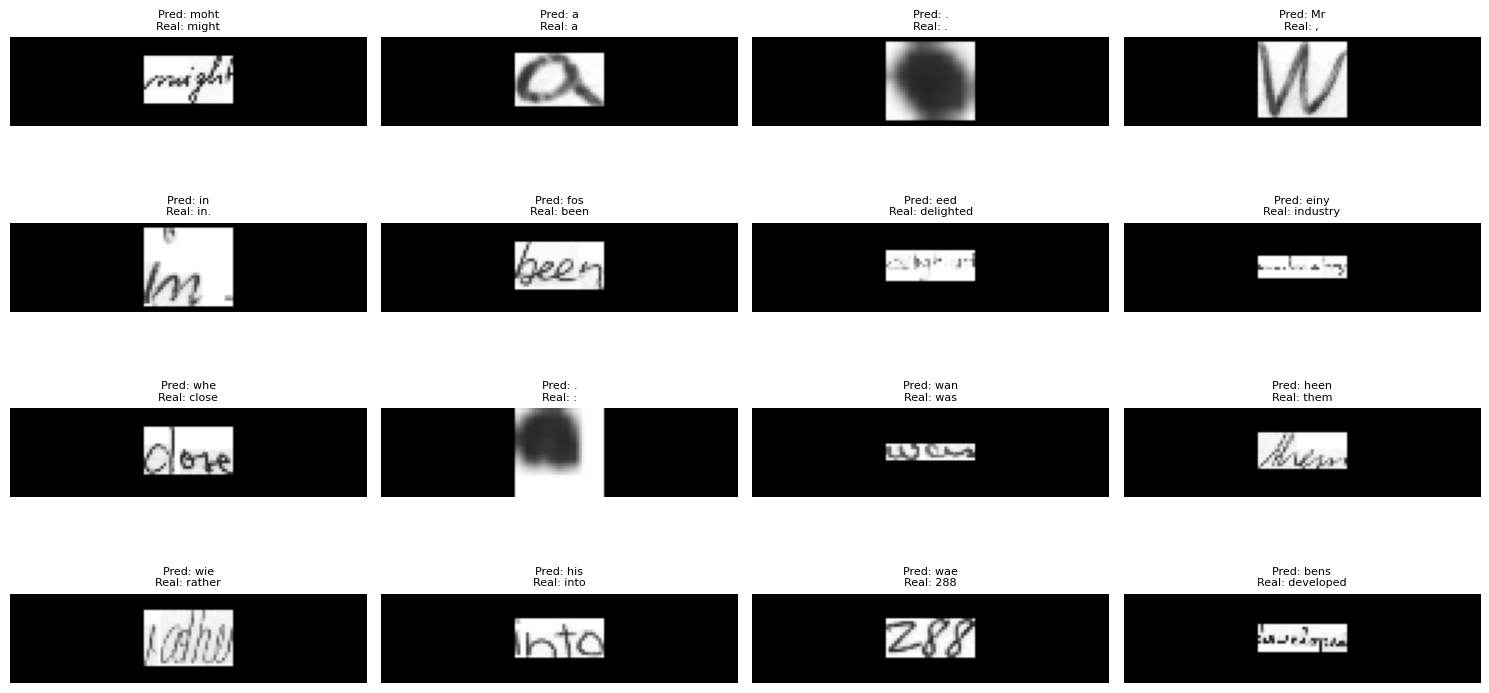

In [134]:
import matplotlib.pyplot as plt

# Tomamos un batch del val_ds
for batch in val_ds.take(1):
    images = batch["image"]
    labels = batch["label"]

    predicciones = prediction_model.predict(images)
    textos_predichos = decodificar_predicciones(predicciones)

    _, axes = plt.subplots(4, 4, figsize=(15, 8))
    for i in range(16):
        img = images[i].numpy()
        img = (img * 255).astype("uint8")[:, :, 0]

        # Obtener etiqueta real
        indices = tf.gather(labels[i], tf.where(labels[i] != padding_token))
        texto_real = tf.strings.reduce_join(num_to_char(indices)).numpy().decode("utf-8")

        # Mostrar
        axes[i // 4, i % 4].imshow(img, cmap="gray")
        axes[i // 4, i % 4].set_title(f"Pred: {textos_predichos[i]}\nReal: {texto_real}", fontsize=8)
        axes[i // 4, i % 4].axis("off")

    plt.tight_layout()
    plt.show()
    break